2024-06-02 21:28:11.472852: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-02 21:28:13.796776: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-02 21:28:13.840288: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


Epoch 1/10


I0000 00:00:1717331295.114353   89730 service.cc:145] XLA service 0x781a3c00a190 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717331295.114390   89730 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-06-02 21:28:15.130162: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-02 21:28:15.202837: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 149/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0989

I0000 00:00:1717331296.178532   89730 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step - loss: 0.0394 - val_loss: 0.0130
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0120 - val_loss: 0.0105
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0102 - val_loss: 0.0097
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0096 - val_loss: 0.0094
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0087 - val_loss: 0.0088
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


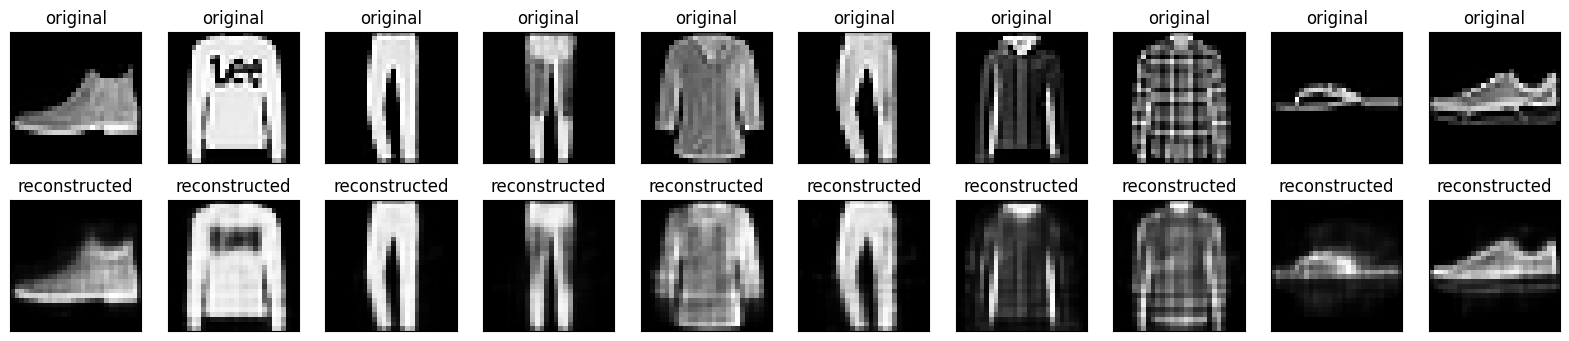

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.datasets import fashion_mnist
from keras.models import Model

(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

print("GPU:",tf.config.list_physical_devices("GPU"))

encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()


In [ ]:
import cupy as cp

memsize=3.5

mempool=cp.get_default_memory_pool()
mempool.set_limit(memsize*1024**3)
print("memsize:",mempool.get_limit())

with cp.cuda.Device(0): # explicit device
  x=cp.array([q for q in range(10000)])
  l2=cp.linalg.norm(x)
  print("At:",l2.device)

xNumpy=cp.asnumpy(l2)
xNumpy=l2.get()

